# Transformator

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
f =     10**5       # Frequenz in HZ
R1 =    800.0         # Primärwiderstand in Ohm
Lp =    0.00005   # Primärinduktivität in H    
Lps =   150.0*10**-6  # Streuinduktivität in H
Lsp =   150.0*10**-6  # Streuinduktivität in H
R2 =    6.0           # Sekundärwiderstand in Ohm
Ls =    500*10**-6  # Sekundärinduktivität in H
U0 =    4.0           # Leerlaufspannung in V

print("f:", f, " R1:", R1, " Lp:", Lp, " Lps:", Lps, " Lsp:", Lsp, " R2:", R2, " Ls:", Ls, " U0:", U0)


f: 100000  R1: 800.0  Lp: 5e-05  Lps: 0.00015  Lsp: 0.00015  R2: 6.0  Ls: 0.0005  U0: 4.0


### Aufgabe 1: Differenzialgleichung für Primär und Sekundärstromkreis

### Aufgabe 2: Differenzialgleichungssystem Aufstellen

### Aufgabe 3: GLS lösen mit Eueler-vorwärts, Stabilitätsgrenze ermitteln für die Schrittweite tau.

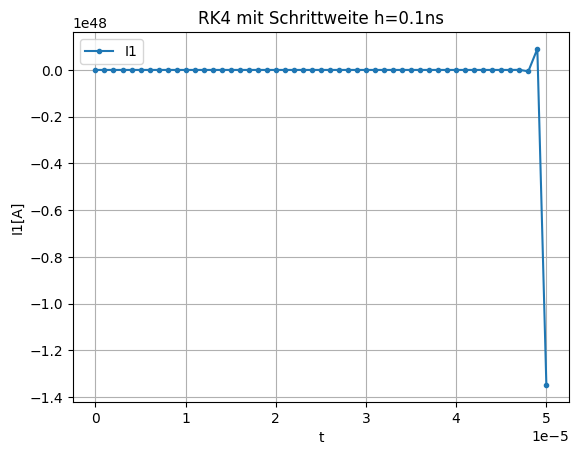

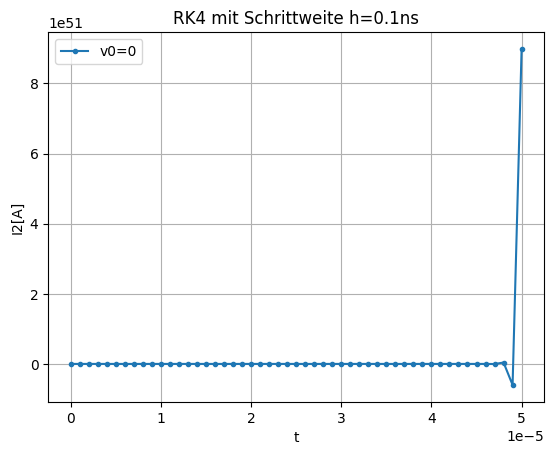

In [72]:
def eulerforward_2Systeme(t0, x0, h, tend, f):
    # t0: Anfangszeit
    # x0: Anfangswerte
    # h: Schrittweite
    # tend: Zeit bis zum Ende
    # f: Funktion mit n Gleichungen
    N = int(tend / h) +1

    # Vektor mit dx-daten und x-daten
    x = np.zeros((N, np.shape(x0)[0]))

    # Zeitvektor
    t = np.zeros((N))
    
    x[0][0] = x0[0]
    x[0][1] = x0[1]

    for i in range(1, N):
        t[i] = t[i-1] + h

        k1 = f(t[i], x[i-1,:])
        x[i, 0] = x[i-1, 0] + h*k1[1] #dx
        x[i, 1] = x[i-1, 1] + h*k1[0] #x

    return t, x

def model2(t, x):
    t = t
    x0 = x[0] # I1
    x1 = x[1] # I2

    U0 = 4*np.sin(2*np.pi*f*t)
    return np.array([(R2*x0*Lps*Ls - R1*x1*(1/Lp)-U0) / (1 - (Lsp*Lps*Ls)),
                      ((R1*x1)-U0)/((Lp/Lsp)-Lps)])

x0 = (0.0, 0.0)
tend = 0.00005
h =    0.00000001

t2, I_x2 = eulerforward_2Systeme(0, x0,h,tend, model2)

# =================== Plot erstellen ===================
plt.figure(1)
plt.plot(t2, I_x2[:,0],  '.-', label='I1')
plt.ylabel('I1[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)

plt.figure(2)
plt.plot(t2, I_x2[:,1],  '.-', label='v0=0')
plt.ylabel('I2[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)
plt.show()

### Aufgabe 4: GLS lösen mit Eueler-rückwärts

[[ 0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000]
 [ 6.79635562e-001 -1.12980443e-004]
 [ 5.02682868e+006 -7.51189460e+002]
 [ 3.71802211e+013 -5.55606550e+009]
 [ 2.74998201e+020 -4.10946458e+016]
 [ 2.03398496e+027 -3.03950685e+023]
 [ 1.50440796e+034 -2.24812788e+030]
 [ 1.11271389e+041 -1.66279571e+037]
 [ 8.23002951e+047 -1.22986313e+044]
 [ 6.08722391e+054 -9.09650716e+050]
 [ 4.50232833e+061 -6.72810175e+057]
 [ 3.33008291e+068 -4.97634447e+064]
 [ 2.46304832e+075 -3.68068219e+071]
 [ 1.82175855e+082 -2.72236407e+078]
 [ 1.34743772e+089 -2.01355775e+085]
 [ 9.96613087e+095 -1.48929926e+092]
 [ 7.37130652e+102 -1.10153895e+099]
 [ 5.45208170e+109 -8.14737571e+105]
 [ 4.03255445e+116 -6.02609021e+112]
 [ 2.98262137e+123 -4.45711165e+119]
 [ 2.20605334e+130 -3.29663905e+126]
 [ 1.63167588e+137 -2.43831204e+133]
 [ 1.20684579e+144 -1.80346271e+140]
 [ 8.92626270e+150 -1.33390547e+147]
 [ 6.60218286e+157 -9.86604149e+153]
 [ 4.88321036e+164 -7.29727684e+160]
 

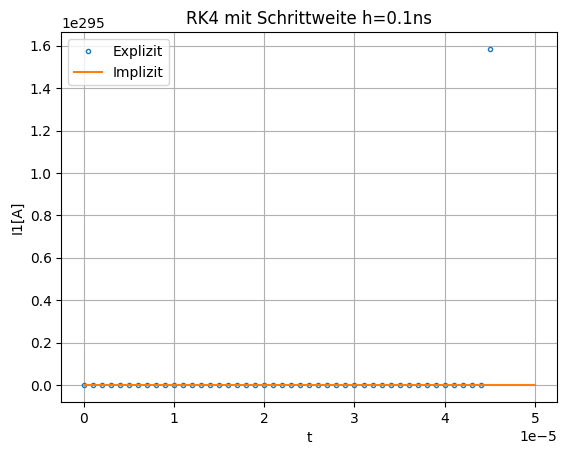

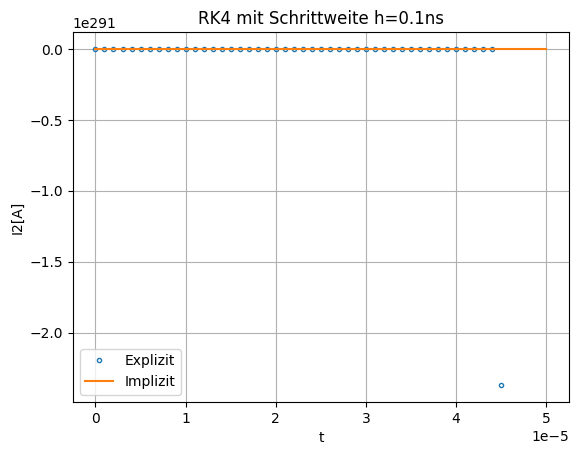

In [73]:
# C | A  =  1/2 | 1/2
#   | B  =      | 1
def runga_kutta_RK4_2Systeme_implizit(x0, h, tend, f, df, tol):
    # x0: Startpunkt
    # X: Endpunkt
    # f: Funktion
    # df: Jacobi Matrix der Funktion f
    # N: Anzahl der Schritte
    # tol: Toleranz
    max_iter=20

    N = int(tend / h)+1
    t = np.zeros(N)
    x = np.zeros((N,np.shape(x0)[0]))
   
    x[0,:] = x0
    k = f(t[0], x[0,:])

    for i in range(1,N):
        step = 0
        t[i] = t[i-1] + h

        r = k - f(t[i-1], x[i-1] + h*k)
        J = -df(t[i-1] + h, x[i-1] + h*k)
        # einheitsmatrix:
        I2 = np.eye(2)
        M = I2 - h * J

        while all(np.abs(value) > tol for value in r) and step < max_iter :
            # Solve linear system with LR
            b = -r
            ATA = np.dot(M.T, M)
            ATb = np.dot(M.T, b)
            delta_k = np.linalg.solve(ATA, ATb)
            k = k + delta_k
            r = k - f(t[i-1] + h, x[i-1] + h*k)

            step += 1

        x[i,:] = x[i-1,:] + h*k
       
    return x, t


def model1(t, x):
    t = t
    x1 = x[0] # I1
    x0 = x[1] # I2

    U0 = 4*np.sin(2*np.pi*f*t)
    return np.array([(R2*x0*Lps*Ls - R1*x1*(1/Lp)-U0) / (1 - (Lsp*Lps*Ls)),
                      ((R1*x1)-U0)/((Lp/Lsp)-Lps)])

def model1_df(x,y):
    return np.array([[-(R1*1/Lp)/(1-Lps*Lsp*1/Ls),-(R2*1/Ls*Lps)/(1-Lps*Lsp*1/Ls)],
                     [(R1/(Lp/Lsp)-Lps),0]])



# Anfangswerte, Endzeitpunkt und Schrittweite einstellen
x0 = (0.0, 0.0)
tend = 0.00005
h =    0.00000001


x_imp, t_imp = runga_kutta_RK4_2Systeme_implizit(x0, h, tend, model1, model1_df, 1e-3)

print(x_imp)
# =================== Plot erstellen ===================
plt.figure(3)
plt.plot(t_imp, x_imp[:,0],  '.', label='Explizit', markerfacecolor='none')
plt.plot(t2, I_x2[:,1],  '-', label='Implizit')
plt.ylabel('I1[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)

plt.figure(4)
plt.plot(t_imp, x_imp[:,1],  '.', label='Explizit', markerfacecolor='none')
plt.plot(t2, I_x2[:,0],  '-', label='Implizit')
plt.ylabel('I2[A]')
plt.xlabel('t')
plt.title('RK4 mit Schrittweite h=0.1ns')
plt.legend()
plt.grid(True)
plt.show()

### Aufgabe 5: GLS lösen mit impliziter Trapezregel und die Lösungen miteinandern vergleichen hinsichtlich der Genauigkeit, Rechenaufwand und Konvergenz.